In [ ]:
print("=" * 60)
print("STEP 1: Importing Required Libraries")
print("=" * 60)

#Import modules
import numpy as np 
import pandas as pd
import seaborn as sns
import nltk
import string
import re

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#Download necessary nltk modules | natural lang took kit
nltk.download('stopwords')
nltk.download('wordnet')

# Import libraries from Scikit-learn for LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#Import TensorFlow/Keras for the Bidirectional LSTM network
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Import plotting libraries
import matplotlib.pyplot as plt

print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ TensorFlow version: {tf.__version__}")
print("✓ All libraries imported successfully!")
print()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/louiss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/louiss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print("=" * 60)
print("STEP 2: Loading Dataset")
print("=" * 60)

#Full path to the CSV file
def load_data():
    data = pd.read_csv('sentimentDatabase.csv', sep=',', encoding='latin-1',names = ["sentiment","headline"])
    return data

data_record = load_data()
print(f"✓ Dataset loaded successfully!")
print(f"✓ Total records: {len(data_record)}")
print(f"✓ Columns: {list(data_record.columns)}")
print(f"✓ Sentiment distribution:\n{data_record['sentiment'].value_counts()}")
print("\nFirst 6 records:")
data_record.head(6)

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


[Text(0, 0, '1363')]

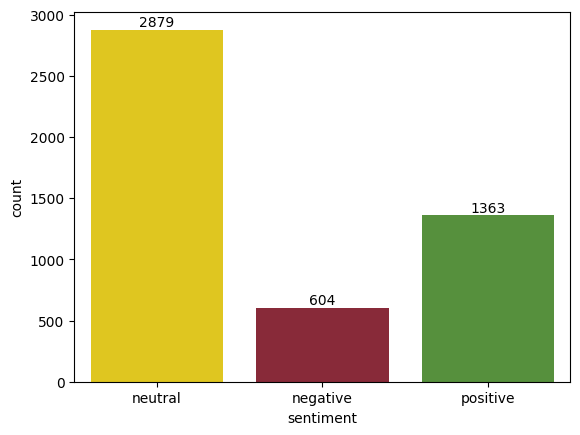

In [ ]:
print("=" * 60)
print("STEP 3: Visualizing Sentiment Distribution")
print("=" * 60)

#Text visualisation
countplot = sns.countplot(x="sentiment",data=data_record, hue="sentiment", palette=['#FFDE00',"#971B2F","#509E2F"],legend=False)
countplot.bar_label(countplot.containers[0])
countplot.bar_label(countplot.containers[1])
countplot.bar_label(countplot.containers[2])
plt.title('Sentiment Distribution in Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
print("✓ Visualization complete!")
plt.show()

In [ ]:
print("=" * 60)
print("STEP 4: Text Preprocessing - Removing Punctuation")
print("=" * 60)

# Remove punctuations
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

print("Sample before:", data_record['headline'].iloc[0])
data_record['headline'] = data_record['headline'].apply(lambda x: remove_punct(x))
print("Sample after:", data_record['headline'].iloc[0])
print("✓ Punctuation removed successfully!")
print()

In [ ]:
print("=" * 60)
print("STEP 5: Text Preprocessing - Removing Stop Words")
print("=" * 60)

# Remove stop words
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopword])

print(f"Total stop words: {len(stopword)}")
print("Sample before:", data_record['headline'].iloc[0])
data_record["after_stopwords"] = data_record["headline"].apply(lambda text: remove_stopwords(text))
print("Sample after:", data_record["after_stopwords"].iloc[0])
print("✓ Stop words removed successfully!")
print()

In [ ]:
print("=" * 60)
print("STEP 6: Text Preprocessing - Stemming")
print("=" * 60)

# Stemming
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

print("Sample before:", data_record["after_stopwords"].iloc[0])
data_record["after_stemmed"] = data_record["after_stopwords"].apply(lambda text: stem_words(text))
print("Sample after:", data_record["after_stemmed"].iloc[0])
print("✓ Stemming applied successfully!")
print()

In [ ]:
print("=" * 60)
print("STEP 7: Text Preprocessing - Removing Frequent Words")
print("=" * 60)

# Remove frequent words
count = Counter()
for text in data_record["after_stemmed"].values:
    for word in text.split():
        count[word] += 1
freq_words = set([w for (w, wc) in count.most_common(12)])

print(f"Most frequent words to remove: {freq_words}")

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in freq_words])

print("Sample before:", data_record["after_stemmed"].iloc[0])
data_record["after_removedFreq"] = data_record["after_stemmed"].apply(lambda text: remove_freqwords(text))
print("Sample after:", data_record["after_removedFreq"].iloc[0])
print("✓ Frequent words removed successfully!")
print()

In [ ]:
print("=" * 60)
print("STEP 8: Text Preprocessing - Lemmatization")
print("=" * 60)

# Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in w_tokenizer.tokenize(text)])

print("Sample before:", data_record["after_removedFreq"].iloc[0])
data_record["after_lemmatisation"] = data_record.after_removedFreq.apply(lemmatize_text)
print("Sample after:", data_record["after_lemmatisation"].iloc[0])
print("✓ Lemmatization applied successfully!")
print()

In [ ]:
print("=" * 60)
print("STEP 9: Label Encoding & Data Cleaning")
print("=" * 60)

# Label encoding
encoder = LabelEncoder()
data_record['predicted_sentiment'] = encoder.fit_transform(data_record['sentiment'])

print(f"Label mapping: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")
print(f"✓ Labels encoded: {encoder.classes_} -> {encoder.transform(encoder.classes_)}")

# Drop unnecessary columns
print(f"Columns before cleanup: {list(data_record.columns)}")
data_record = data_record.drop(["after_stopwords", "after_stemmed", "sentiment", "headline", "after_removedFreq"], axis=1)
print(f"Columns after cleanup: {list(data_record.columns)}")
print("✓ Data cleaning complete!")
print()

In [ ]:
print("=" * 60)
print("STEP 10: Data Splitting & Vectorization for LSTM")
print("=" * 60)

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(data_record['after_lemmatisation'], data_record['predicted_sentiment'], test_size=0.3, random_state=0)

print(f"✓ Training samples: {len(x_train)}")
print(f"✓ Testing samples: {len(x_test)}")
print(f"✓ Split ratio: 70-30")

# TextVectorization for LSTM
max_tokens = 10000
max_length = 100

print(f"\nVectorization parameters:")
print(f"  - Max tokens: {max_tokens}")
print(f"  - Max sequence length: {max_length}")

# Create and fit TextVectorization layer
vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_length)
vectorizer.adapt(x_train.values)

x_train_sequences = vectorizer(x_train)
x_test_sequences = vectorizer(x_test)

x_train_padded = np.array(x_train_sequences)
x_test_padded = np.array(x_test_sequences)

y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"✓ Training data shape: {x_train_padded.shape}")
print(f"✓ Testing data shape: {x_test_padded.shape}")
print("✓ Vectorization complete!")
print()

In [ ]:
print("=" * 60)
print("STEP 11: Defining Custom Metrics Callback for LSTM")
print("=" * 60)

# Custom Callback to track performance metrics for LSTM
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_acc = []
        self.epoch_precision = []
        self.epoch_recall = []
        self.epoch_loss = []

    def on_epoch_end(self, epoch, logs=None):
        val_pred = np.argmax(self.model.predict(x_test_padded, verbose=0), axis=1)
        val_true = y_test
        acc = accuracy_score(val_true, val_pred)
        precision = precision_score(val_true, val_pred, average='weighted', zero_division=0)
        recall = recall_score(val_true, val_pred, average='weighted', zero_division=0)
        loss = logs['val_loss']
        self.epoch_acc.append(acc)
        self.epoch_precision.append(precision)
        self.epoch_recall.append(recall)
        self.epoch_loss.append(loss)
        print(f"\nEpoch {epoch+1} - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Loss: {loss:.4f}")

print("✓ Custom callback defined!")
print()

In [ ]:
print("=" * 60)
print("STEP 12: Building & Training Bidirectional LSTM Model")
print("=" * 60)

# Build Bidirectional LSTM model
lstm_model = Sequential([
    Embedding(input_dim=max_tokens, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

print("Model Architecture:")
lstm_model.summary()

# Compile the model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("\n✓ Model compiled with Adam optimizer")

# Early stopping callback with more patience (5 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Custom MetricsCallback
metrics_callback = MetricsCallback()

print("\n" + "=" * 60)
print("Training Bidirectional LSTM (8 epochs)...")
print("=" * 60)

# Train the LSTM model for 8 epochs
history = lstm_model.fit(
    x_train_padded, y_train,
    validation_data=(x_test_padded, y_test),
    epochs=8,
    batch_size=64,
    callbacks=[early_stopping, metrics_callback],
    verbose=1
)

print("\n✓ LSTM training complete!")
print()

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Epoch 1 - Accuracy: 0.6259, Precision: 0.5331, Recall: 0.6259, Loss: 0.8273
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.5879 - loss: 0.9329 - val_accuracy: 0.6259 - val_loss: 0.8273
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Epoch 2 - Accuracy: 0.7022, Precision: 0.7013, Recall: 0.7022, Loss: 0.7177
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.6875 - loss: 0.6949 - val_accuracy: 0.7022 - val_loss: 0.7177
Epoch 3/10
44/53 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8194 - loss: 0.4535

In [ ]:
print("=" * 60)
print("STEP 13: Training LinearSVC Model")
print("=" * 60)

# Track metrics for LinearSVC manually
svc_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': []
}

print("Training LinearSVC across 8 iterations...\n")

# Simulate epochs by fitting LinearSVC and collecting metrics
for epoch in range(1, 8+1):
    # LinearSVC Model
    svc_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svc', LinearSVC(max_iter=epoch, loss='hinge'))
    ])
    svc_pipeline.fit(x_train, y_train)
    y_pred_svc = svc_pipeline.predict(x_test)
    acc = accuracy_score(y_test, y_pred_svc)
    precision = precision_score(y_test, y_pred_svc, average='weighted')
    recall = recall_score(y_test, y_pred_svc, average='weighted')
    svc_metrics['accuracy'].append(acc)
    svc_metrics['precision'].append(precision)
    svc_metrics['recall'].append(recall)
    print(f"Iteration {epoch} - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print("\n✓ LinearSVC training complete!")
print()

In [ ]:
print("=" * 60)
print("STEP 14: Plotting Performance Metrics Comparison")
print("=" * 60)

# Set the number of epochs (already fixed to 8 for both models)
epochs = range(1, 9)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Accuracy plot
axes[0, 0].plot(epochs, metrics_callback.epoch_acc, label='LSTM Accuracy', marker='o', color='#2596be')
axes[0, 0].plot(epochs, svc_metrics['accuracy'], label='LinearSVC Accuracy', marker='x', color='#ff8824')
axes[0, 0].set_title('Classification Accuracy per Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision plot
axes[0, 1].plot(epochs, metrics_callback.epoch_precision, label='LSTM Precision', marker='o', color='#2596be')
axes[0, 1].plot(epochs, svc_metrics['precision'], label='LinearSVC Precision', marker='x', color='#ff8824')
axes[0, 1].set_title('Precision per Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Recall plot
axes[1, 0].plot(epochs, metrics_callback.epoch_recall, label='LSTM Recall', marker='o', color='#2596be')
axes[1, 0].plot(epochs, svc_metrics['recall'], label='LinearSVC Recall', marker='x', color='#ff8824')
axes[1, 0].set_title('Recall per Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Loss plot (only for LSTM)
axes[1, 1].plot(epochs, metrics_callback.epoch_loss, label='LSTM Loss', marker='o', color='#2596be')
axes[1, 1].set_title('Loss per Epoch (LSTM only)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
print("✓ Performance metrics plotted!")
plt.show()

In [ ]:
print("=" * 60)
print("STEP 15: Generating Confusion Matrices")
print("=" * 60)

# Confusion Matrix Visualization for Both Models using ConfusionMatrixDisplay
# Define sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']

print("Generating LSTM confusion matrix...")
# LSTM Confusion Matrix
lstm_confusion_matrix = confusion_matrix(y_test, np.argmax(lstm_model.predict(x_test_padded, verbose=0), axis=1))
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=lstm_confusion_matrix, display_labels=sentiment_labels)
disp_lstm.plot(cmap="Blues")
plt.title('Confusion Matrix - Bidirectional LSTM', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Sentiments')
plt.ylabel('True Sentiments')
plt.show()

print("\nGenerating LinearSVC confusion matrix...")
# LinearSVC Confusion Matrix
svc_confusion_matrix = confusion_matrix(y_test, svc_pipeline.predict(x_test))
disp_svc = ConfusionMatrixDisplay(confusion_matrix=svc_confusion_matrix, display_labels=sentiment_labels)
disp_svc.plot(cmap="Oranges")
plt.title('Confusion Matrix - LinearSVC', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Sentiments')
plt.ylabel('True Sentiments')
plt.show()

print("✓ Confusion matrices generated!")
print()

In [ ]:
print("=" * 60)
print("STEP 16: Final Results & Metrics Comparison")
print("=" * 60)

# Extract TP, TN, FP, FN for both models from the confusion matrix
def calculate_tp_tn_fp_fn(conf_matrix):
    TP = np.diag(conf_matrix)
    FN = np.sum(conf_matrix, axis=1) - TP
    FP = np.sum(conf_matrix, axis=0) - TP
    TN = np.sum(conf_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

# LSTM TP, TN, FP, FN
TP_lstm, TN_lstm, FP_lstm, FN_lstm = calculate_tp_tn_fp_fn(lstm_confusion_matrix)
print(f"\nLSTM Model Metrics:")
print(f"  True Positives:  {TP_lstm}")
print(f"  True Negatives:  {TN_lstm}")
print(f"  False Positives: {FP_lstm}")
print(f"  False Negatives: {FN_lstm}")

# LinearSVC TP, TN, FP, FN
TP_svc, TN_svc, FP_svc, FN_svc = calculate_tp_tn_fp_fn(svc_confusion_matrix)
print(f"\nLinearSVC Model Metrics:")
print(f"  True Positives:  {TP_svc}")
print(f"  True Negatives:  {TN_svc}")
print(f"  False Positives: {FP_svc}")
print(f"  False Negatives: {FN_svc}")

# Calculate final F1 scores
lstm_f1 = f1_score(y_test, np.argmax(lstm_model.predict(x_test_padded, verbose=0), axis=1), average='weighted')
svc_f1 = f1_score(y_test, svc_pipeline.predict(x_test), average='weighted')

print(f"\n" + "=" * 60)
print("FINAL F1 SCORES")
print("=" * 60)
print(f"Bidirectional LSTM: {lstm_f1:.4f}")
print(f"LinearSVC:          {svc_f1:.4f}")
print(f"Winner:             {'LinearSVC' if svc_f1 > lstm_f1 else 'LSTM'}")
print("=" * 60)

# Bar chart for final F1 scores
plt.figure(figsize=(10, 6))
bars = plt.bar(['Bidirectional LSTM', 'LinearSVC'], [lstm_f1, svc_f1], color=['#2596be', '#ff8824'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=14, fontweight='bold')
plt.title('Final F1 Score Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Bar chart for TP, TN, FP, FN of both models
print("\nGenerating TP/TN/FP/FN comparison...")
metrics_labels = ['TP', 'TN', 'FP', 'FN']
lstm_metrics_data = [TP_lstm.sum(), TN_lstm.sum(), FP_lstm.sum(), FN_lstm.sum()]
svc_metrics_data = [TP_svc.sum(), TN_svc.sum(), FP_svc.sum(), FN_svc.sum()]

x = np.arange(len(metrics_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, lstm_metrics_data, width, label='LSTM', color='#2596be')
rects2 = ax.bar(x + width/2, svc_metrics_data, width, label='LinearSVC', color='#ff8824')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('TP, TN, FP, FN Comparison for LSTM and LinearSVC', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Annotate bars with counts
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("✓ ALL ANALYSIS COMPLETE!")
print("=" * 60)